<a href="https://colab.research.google.com/github/nahumsa/Entanglement-VAE/blob/master/VAE%20Entanglement%20Witness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [1]:
!git clone https://github.com/nahumsa/Entanglement-VAE.git

Cloning into 'Entanglement-VAE'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 113 (delta 48), reused 20 (delta 6), pack-reused 0
Receiving objects: 100% (113/113), 8.05 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
!pip install qutip

     |████████████████████████████████| 3.5MB 2.8MB/s 
  Created wheel for qutip: filename=qutip-4.5.0-cp36-cp36m-linux_x86_64.whl size=12884977 sha256=ad62bdc31c65a06379f9daa954bb58dbcff7acec715f5150be2d56c212d5b231
  Stored in directory: /root/.cache/pip/wheels/c9/85/e8/3fbad9a0816141b4c5f1d73d8a880ed91265fea84192cbe37b
Successfully built qutip


In [3]:
% cd Entanglement-VAE/

/content/Entanglement-VAE


## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [4]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import os
import seaborn as sns

# Set Random Seed for reproduction
tf.random.set_seed(1234)

# Changing the figure style
sns.set_context("paper")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

Checking the distribution of the labels.

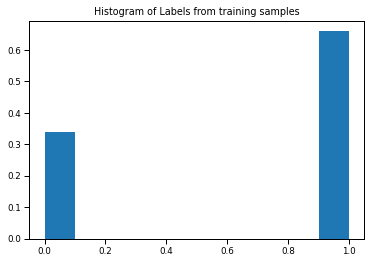

In [7]:
weights = np.ones_like(labels_train)/float(len(labels_train))
plt.hist(labels_train, weights=weights)
plt.title('Histogram of Labels from training samples')
plt.show()

There are more entangled states than separable states as expected.





#Variational Autoencoder for all measurements

In [64]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y:(5000, 2)


In [0]:
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

In [0]:
pal = sns.dark_palette("yellow", as_cmap=True)
sns.set()

Beta: 1 Accuracy: 0.8603333234786987


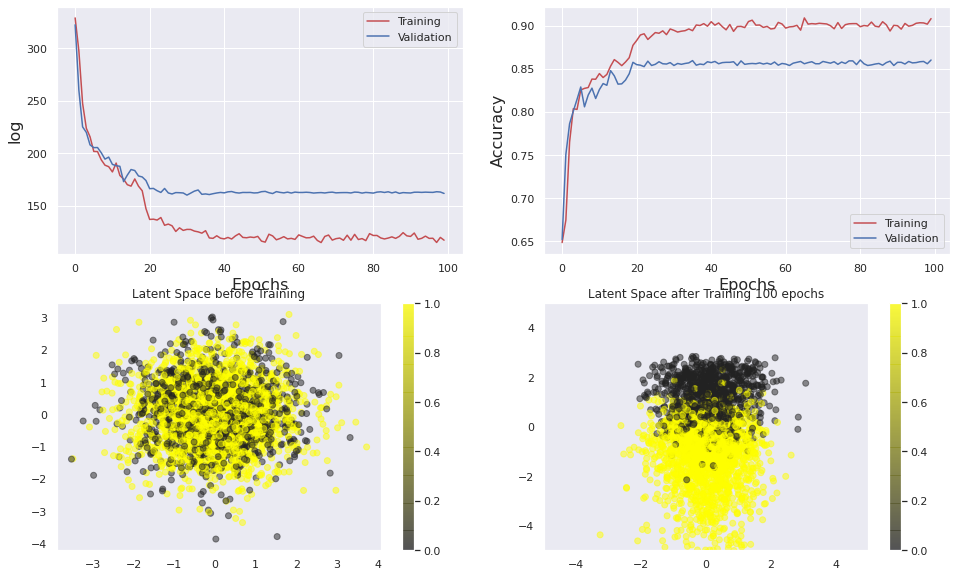

In [69]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Beta: {BETA} Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)


fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])



ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_0 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_0[:, 0], z_mu_0[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()

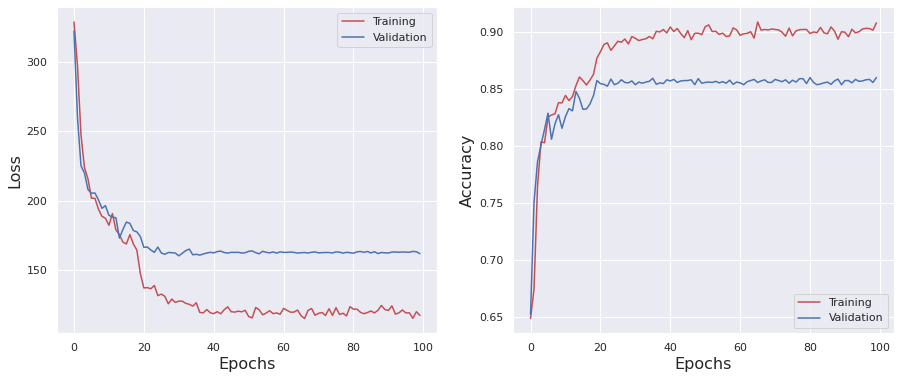

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
#ax1.set_yscale('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

plt.show()

### Using latent space to categorize entanglement

In [25]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_0):
  if latent[0] < 0:
    labels_pred[i] = 1
  
print('Accuracy choosing > 0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing > 0 on latent: 0.8403333333333334


#Variational Autoencoder with limited measurements

## Correlated Measurements

In [52]:
from Utils.Dataset import create_x_correlated

#Transforming in an np.array
X_train = np.array(create_x_correlated(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x_correlated(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 9) 
 Y:(5000, 2)


In [0]:
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement_limited'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

Accuracy: 0.8183333277702332


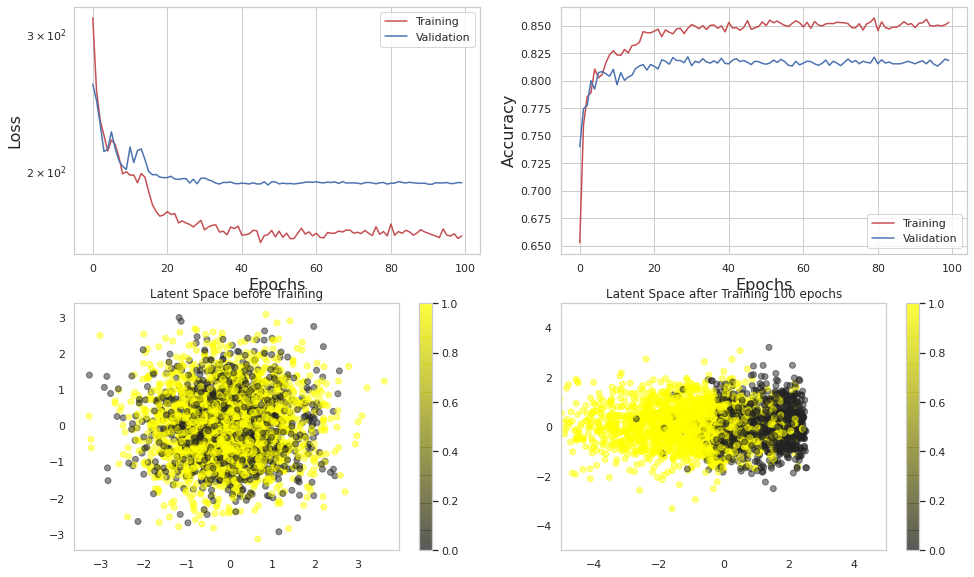

In [63]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_yscale('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_1 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_1[:, 0], z_mu_1[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
plt.colorbar(ims, ax=ax4)
plt.show()

In [40]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_1):
  if latent[1] < 0.:
    labels_pred[i] = 1

print('Accuracy choosing >0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing >0 on latent: 0.8133333333333334


## Uncorrelated Measurements

In [32]:
from Utils.Dataset import create_x_local

#Transforming in an np.array
X_train = np.array(create_x_local(measurements_train))
Y_train = np.array(labels_train)
X_test = np.array(create_x_local(measurements_test))
Y_test = np.array(labels_test)

#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 6) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement_limited'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256,128,52]
decoder_dense = [52,128,256, 512, 2]
batch_norm = False
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [42]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 500
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

Train on 5000 samples, validate on 3000 samples
Epoch 1/100
 - 1s - loss: 328.3624 - accuracy: 0.6536 - vae_r_loss: 327.5592 - vae_kl_loss: 0.8032 - val_loss: 323.1370 - val_accuracy: 0.6520 - val_vae_r_loss: 321.9424 - val_vae_kl_loss: 1.1946
Epoch 2/100
 - 1s - loss: 320.7963 - accuracy: 0.6554 - vae_r_loss: 319.9218 - vae_kl_loss: 0.8746 - val_loss: 317.1888 - val_accuracy: 0.6507 - val_vae_r_loss: 315.8776 - val_vae_kl_loss: 1.3113
Epoch 3/100
 - 1s - loss: 317.4239 - accuracy: 0.6574 - vae_r_loss: 315.4131 - vae_kl_loss: 2.0107 - val_loss: 322.5901 - val_accuracy: 0.6520 - val_vae_r_loss: 321.2313 - val_vae_kl_loss: 1.3587
Epoch 4/100
 - 1s - loss: 315.7543 - accuracy: 0.6568 - vae_r_loss: 313.7231 - vae_kl_loss: 2.0313 - val_loss: 311.1307 - val_accuracy: 0.6540 - val_vae_r_loss: 309.1204 - val_vae_kl_loss: 2.0103
Epoch 5/100
 - 1s - loss: 311.0960 - accuracy: 0.6558 - vae_r_loss: 308.6136 - vae_kl_loss: 2.4824 - val_loss: 310.1412 - val_accuracy: 0.6520 - val_vae_r_loss: 308.202

Accuracy: 0.6776666641235352


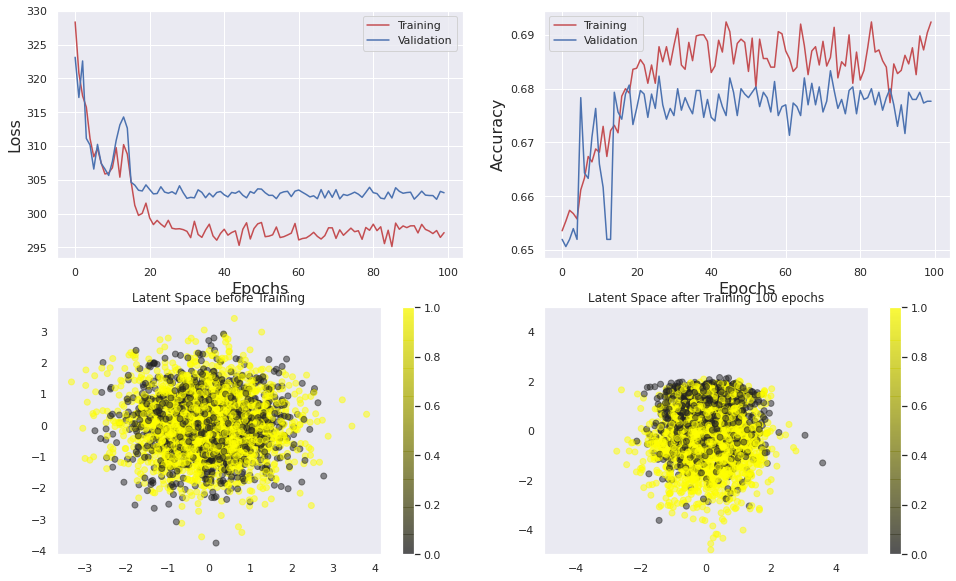

In [43]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f'Accuracy: {val_accuracy[-1]}')

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig = plt.figure(figsize=(16,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu_2 = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu_2[:, 0], z_mu_2[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
ax4.set_ylim(-5,5)
ax4.set_xlim(-5,5)
plt.colorbar(ims, ax=ax4)
plt.show()

In [37]:
labels_pred = np.zeros(len(labels_test), dtype=int)
for i,latent in enumerate(z_mu_2):
  if latent[1] > 0:
    labels_pred[i] = 1

print('Accuracy choosing >0 on latent: {}'.format(np.sum(Y_test == labels_pred)/len(Y_test)))

Accuracy choosing >0 on latent: 0.5026666666666667


# Other Plots

## Varying $\beta$

This is done running each time for a different $\beta$.

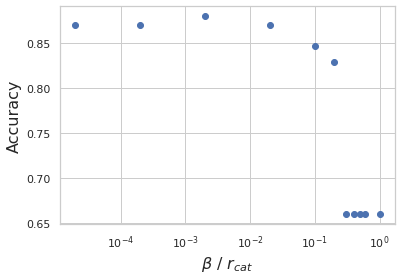

In [46]:
sns.set_style("whitegrid")
beta = [0.01, 0.1, 1, 10, 50, 100, 150, 200, 250, 300, 500]
beta = np.array(beta)/np.max(beta)
acc = [0.87, 0.87, 0.88, 0.87, 0.847, 0.829, 0.66, 0.66, 0.66, 0.66, 0.66]
plt.plot(beta, acc, 'o');
plt.xlabel(r'$\beta$ / $r_{cat}$', size=16)
plt.xscale('log')
plt.ylabel('Accuracy', size=16)
#plt.title(r'Varying $\beta / r_{cat}$')
plt.show()

## Latent Space for all datasets

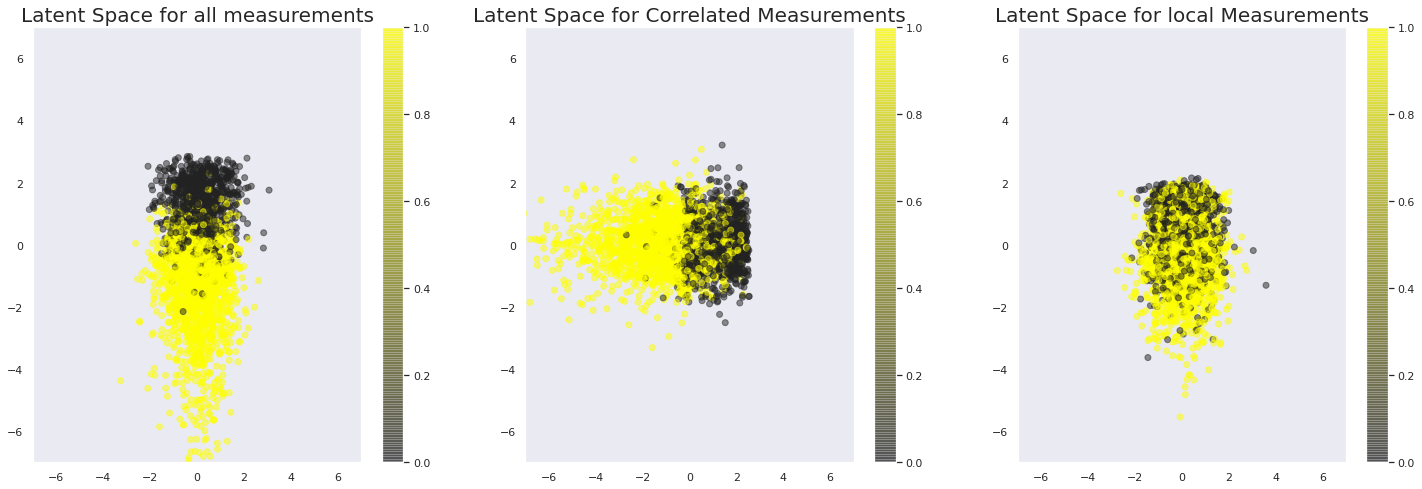

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))

lims= 7

im1 = ax1.scatter(z_mu_0[:, 0], z_mu_0[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax1.set_title(f'Latent Space for all measurements', size=20)
ax1.grid()
ax1.set_ylim(-lims,lims)
ax1.set_xlim(-lims,lims)
plt.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z_mu_1[:, 0], z_mu_1[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax2.set_title(f'Latent Space for Correlated Measurements', size=20)
ax2.grid()
ax2.set_ylim(-lims,lims)
ax2.set_xlim(-lims,lims)
plt.colorbar(im2, ax=ax2)

im3 = ax3.scatter(z_mu_2[:, 0], z_mu_2[:, 1], cmap=pal, alpha=0.5, c=Y_test)
ax3.set_title(f'Latent Space for local Measurements', size=20)
ax3.grid()
ax3.set_ylim(-lims,lims)
ax3.set_xlim(-lims,lims)
plt.colorbar(im3, ax=ax3)
plt.show()

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))

lims = 7

ims = ax1.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.5, c=Y_test)
ax1.set_title(f'Latent Space before Training')
ax1.grid()
plt.colorbar(ims, ax=ax1)

ims = ax2.scatter(z_mu_0[:, 0], z_mu_0[:, 1], alpha=0.5, c=Y_test)
ax2.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax2.set_ylim(-lims,lims)
ax2.set_xlim(-lims,lims)
ax2.grid()
plt.colorbar(ims, ax=ax2)
plt.show()